# Assignment 3 - Inverse Problems 2023 - Emilie Jessen

In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg
import scipy.stats

In [32]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite',
        'grid': 'True'}
mpl.rc('axes', **axes)

In [33]:
# Loading the data
data = np.loadtxt("mars_soil.txt")
x = np.array(data[:,0])
y = np.array(data[:,1])
yerr = np.ones(len(x)) * 0.03*10**4

In [62]:
# Inspecting the data to make initial guess on model parameters 

N_peaks = 20

# Areas
A0 = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, \
      -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000])

# Widths 
c0 = np.array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, \
      0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

# Frequencies 
f0 = np.array([-10.5, -8.8, -7.65, -6.95, -6.45, -5.55, -4.35,-3.65, -3.15, \
      -1.7, 1.7, 3.1, 3.6, 4.25, 5.45, 6.35, 6.85, 7.55, 8.7, 10.5])

# Collecting the initial guess in a vector
m0 = np.zeros(3*N_peaks)

for i in range(N_peaks):
    m0[3*i :3*i + 3] = [A0[i], f0[i], c0[i]]

In [74]:
def fit_data(x, m, peak_shape='Gauss'):
    """Function that takes the model parameters and returns the fit to the data given the shape of the peaks."""

    A = m[::3]
    f = m[1::3]
    c = m[2::3]

    fit = np.zeros(len(x)) + 12500

    if peak_shape == 'Gauss':

        for i in range(N_peaks):
            fit += A[i] * scipy.stats.norm.pdf(x, loc=f[i], scale=c[i])

    else: 
        for i in range(N_peaks):
            fit += A[i] * c[i]**2 / ((x - f[i])**2 + c[i]**2)

    return fit

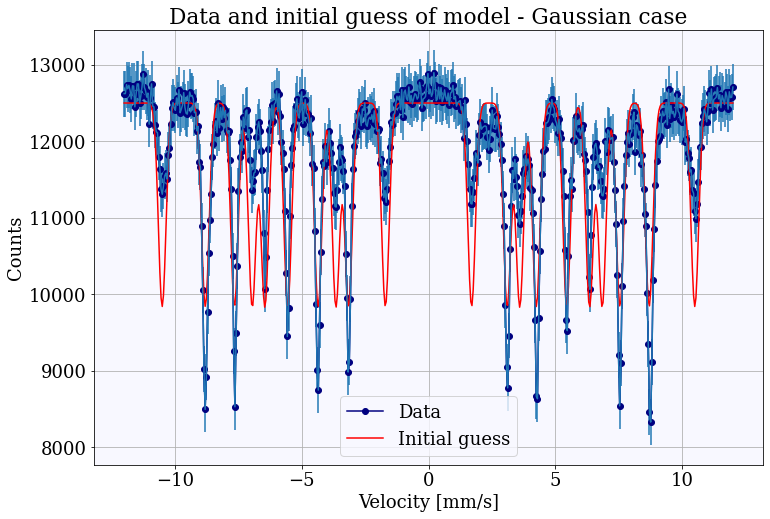

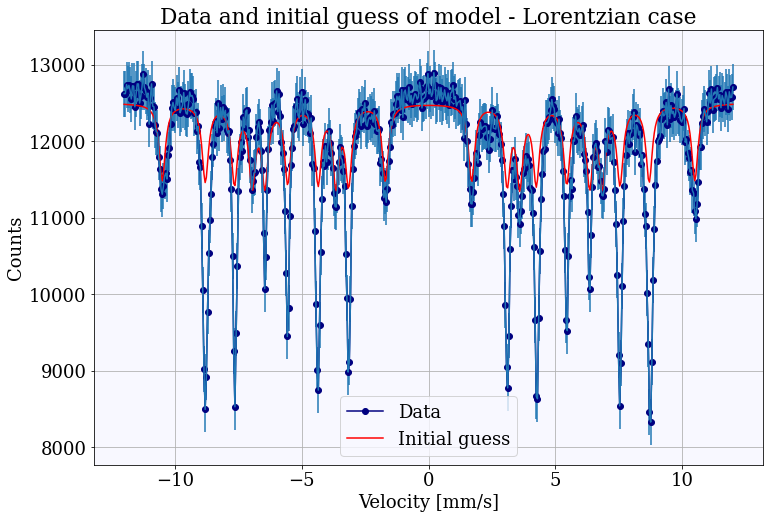

In [78]:
init_gauss = fit_data(x, m0, 'Gauss')
init_lorentz = fit_data(x, m0, 'Lorentz')

# Visualising the data and initial estimate of the model - Gaussian case 

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y, '-o', label='Data', color='navy')
ax.plot(x, init_gauss, label='Initial guess', color='red')
ax.errorbar(x, y, yerr=yerr)
ax.set(xlabel='Velocity [mm/s]', 
       ylabel='Counts',
       title='Data and initial guess of model - Gaussian case')
ax.legend();

# Visualising the data and initial estimate of the model - Lorentzian case 

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y, '-o', label='Data', color='navy')
ax.plot(x, init_lorentz, label='Initial guess', color='red')
ax.errorbar(x, y, yerr=yerr)
ax.set(xlabel='Velocity [mm/s]', 
       ylabel='Counts',
       title='Data and initial guess of model - Lorentzian case')
ax.legend();


1. Using the forward relation: $\mathbf{d} = g(\mathbf{m})$ to obtain the analytical formulas for the derivatives. In the code below the expressions for the Gaussian case are implemented. 

$$  \frac{\partial{g_i}}{\partial{A_p}} = \frac{1}{\sqrt{2\pi}c_p} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]}$$


$$  \frac{\partial{g_i}}{\partial{f_p}} = \frac{A_p}{\sqrt{2\pi}c_p} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} \cdot \frac{(z_i - f_p)}{c_p^2}$$

$$  \frac{\partial{g_i}}{\partial{c_p}} = \frac{A_p}{\sqrt{2\pi}} \left( \frac{-1}{c_p^2} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} + \frac{(z_i - f_p)^2}{c_p^4} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} \right)$$

In [37]:
def dGauss_dA(x, A, c, f): 
    const = 1 / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return  const * exp


def dGauss_df(x, A, c, f):
    const = A / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return  const * exp * (x - f) / c**2


def dGauss_dc(x, A, c, f):
    const1 = -A / (np.sqrt(2 * np.pi) * c**2)
    const2 = A / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return const1 * exp + const2 * exp * (x - f)**2 / c**3

2. In the code below the analytical formulas for the derivatives for the Lorentzian case are implemented. 

$$  \frac{\partial{g_i}}{\partial{A_p}} = \frac{c_p^2}{(z_i - f_p)^2 + c_p^2} $$

$$  \frac{\partial{g_i}}{\partial{f_p}} = \frac{A_p c_p^2}{((z_i - f_p)^2 + c_p^2)^2} \cdot 2(z_i - f_p) $$


$$  \frac{\partial{g_i}}{\partial{c_p}} = 2 A_p c_p \left( \frac{1}{(z_i - f_p)^2 + c_p^2} - \frac{c_p^2}{((z_i - f_p)^2 + c_p^2)^2}  \right)$$

In [38]:
def dLorentz_dA(x, A, c, f):
    return c**2 / ((x - f)**2 + c**2)

def dLorentz_df(x, A, c, f):
    nom = (x - f)**2 + c**2
    return A * c**2 / nom**2 * (2 * (x - f))

def dLorentz_dc(x, A, c, f):
    nom = ((x - f)**2 + c**2)
    return 2 * A * c / nom - 2 * A * c**3 / nom**2

3. In the code below a function is implemented to evaluate the derivatives in the solution $\mathbf{m}$ and stored in the G-matrix for the Gaussian and Lorentzian case. The evaluation is shown for the initial estimate on the model parameters.

In [52]:
def G_matrix(x, m, peak_shape='Gauss'): 
    """Function that returns the G matrix for the given model parameters m and the shape of the peaks."""

    A = m[::3]
    f = m[1::3]
    c = m[2::3]

    G = np.zeros((len(m), len(x)))

    if peak_shape == 'Gauss':

        for i in range(len(x)):
            G[::3, i] = dGauss_dA(x[i], A, c, f)
            G[1::3, i] = dGauss_df(x[i], A, c, f)
            G[2::3, i] = dGauss_dc(x[i], A, c, f)

    else:
            
        for i in range(len(x)):
            G[::3, i] = dLorentz_dA(x[i], A, c, f)
            G[1::3, i] = dLorentz_df(x[i], A, c, f)
            G[2::3, i] = dLorentz_dc(x[i], A, c, f)

    return G.T

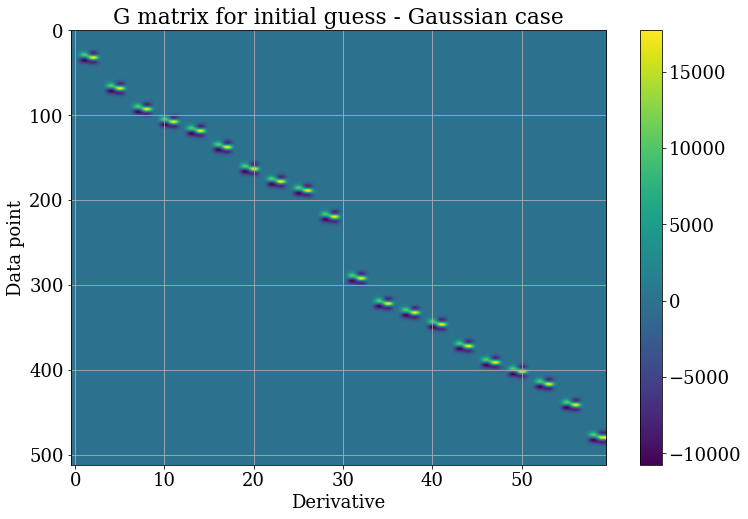

In [50]:
# Visualising the G matrix for the initial estimate of the model - Gaussian case

G0_Gauss = G_matrix(x, m0, 'Gauss')

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(G0_Gauss, aspect='auto')
fig.colorbar(im)
ax.set(xlabel='Derivative', 
       ylabel='Data point i ',
       title='G matrix for initial guess - Gaussian case');

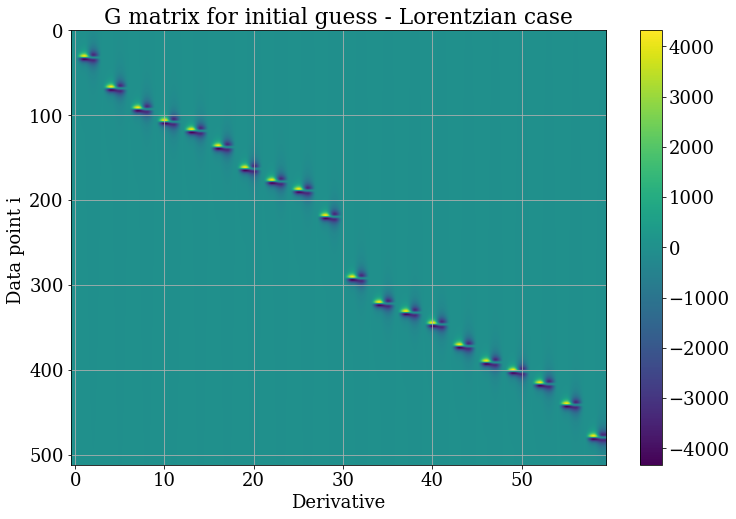

In [53]:
# Visualising the G matrix for the initial estimate of the model - Lorentzian case

G0_Lorentz = G_matrix(x, m0, 'Lorentz')

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(G0_Lorentz, aspect='auto')
fig.colorbar(im)
ax.set(xlabel='Derivative', 
       ylabel='Data point i ',
       title='G matrix for initial guess - Lorentzian case');

In [98]:
# Data covariance matrix - assuming uncorrelated data
C_D = np.diag(yerr**2)

# Model covariance matrix
C_M = np.diag(np.repeat(c0**2, 3))

In [99]:
def steepest_descent(x, y, m0, epsilon, max_iter, peak_shape='Gauss'):
    
    m = m0.copy()

    for _ in range(max_iter):
        G = G_matrix(x, m, peak_shape)
        g = fit_data(x, m, peak_shape)
        
        m_new = m - epsilon * (C_M @ G.T @ np.linalg.inv(C_D) @ (g - y) + (m - m0))
        m = m_new.copy()
        
    return m

In [102]:
m_best = steepest_descent(x, y, m0, 0.0001, 1000, 'Lorentz')

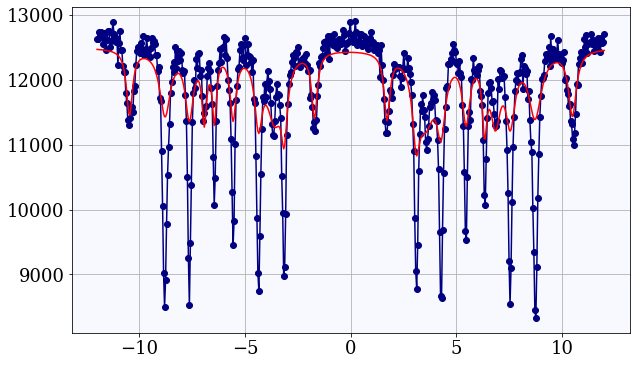

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y, '-o', label='Data', color='navy')
ax.plot(x, fit_data(x, m_best, 'Lorentz'), label='Best fit', color='red')
